# Agrupar Paises segun factores socioeconomicos PCA Y DBSCAN 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
#!pip install -U kaleido
import kaleido

In [2]:
data = pd.read_csv('./Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200


Características categóricas : country
Características numéricas : child_mort exports health imports income inflation life_expec total_fer gdpp


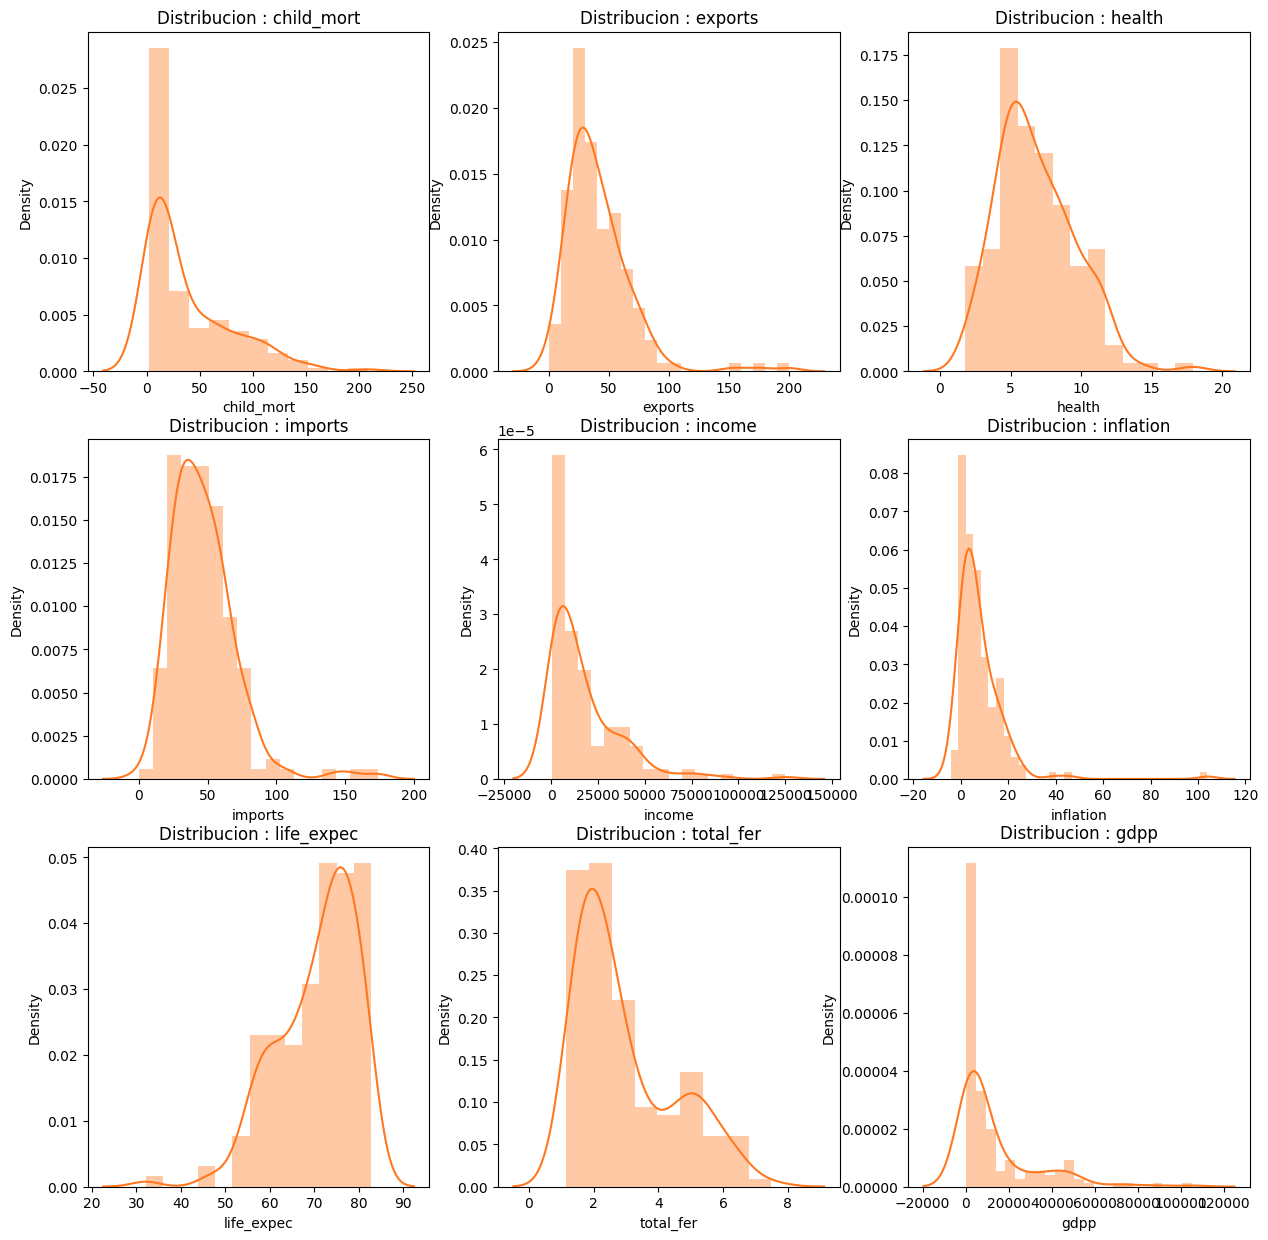

In [3]:
colors = ['#FF781F','#2D2926']
col = list(data.columns)
col.remove('country')
categorical_features = ['country']
numerical_features = [*col]
print('Características categóricas :',*categorical_features)
print('Características numéricas :',*numerical_features)
fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.distplot(data[numerical_features[i]],color = colors[0])
    title = 'Distribucion : ' + numerical_features[i]
    plt.title(title)
plt.show()

## Análisis de componentes principales (PCA):

In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalizacion
ss = StandardScaler() # Standardizacion
df2 = data.copy(deep = True)

col = list(data.columns)
col.remove('health')
col.remove('country')

df2['health'] = ss.fit_transform(df2[['health']]) # Standardizacion

for i in col:
    df2[i] = mms.fit_transform(df2[[i]]) # Normalizacion
df2.drop(columns = 'country',inplace = True) 
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.43,0.05,0.28,0.26,0.01,0.13,0.48,0.74,0.00
1,0.07,0.14,-0.10,0.28,0.07,0.08,0.87,0.08,0.04
2,0.12,0.19,-0.97,0.18,0.10,0.19,0.88,0.27,0.04
3,0.57,0.31,-1.45,0.25,0.04,0.25,0.55,0.79,0.03
4,0.04,0.23,-0.29,0.34,0.15,0.05,0.88,0.15,0.11


#### Valores de varianza de cada característica presente en el conjunto de datos.

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca_df2 = pd.DataFrame(pca.fit_transform(df2))
pca.explained_variance_

array([1.01740511, 0.13090418, 0.03450018, 0.02679822, 0.00979752,
       0.00803398, 0.00307055, 0.00239976, 0.00179388])

#### Valores propios
- Este es un método muy eficaz en el que sumamos las variaciones de todas las características en formato acumulativo.
- Normalmente se seleccionan **valores propios con más del 95 % de la relación de varianza**.
- Corresponden a las columnas del dataframe generado por PCA.
- En este caso, seleccionamos el **Valor propio: 2** ya que los pasos generados tienen variaciones significativas y, por lo tanto, las otras características quedan dominadas por sus variaciones. 

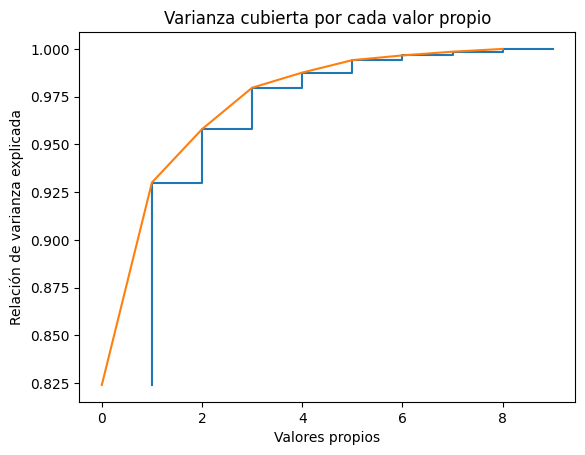

In [14]:
plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Valores propios')
plt.ylabel('Relación de varianza explicada')
plt.title('Varianza cubierta por cada valor propio')
plt.show()

In [7]:
pca_df2 = pca_df2.drop(columns = [3,4,5,6,7,8])
m2 = pca_df2.values # PCA Data
pca_df2.head()

,0,1,2
0,0.22,0.64,0.09
1,-0.08,-0.17,-0.21
2,-0.96,-0.13,-0.13
3,-1.51,0.47,0.28
4,-0.26,-0.24,-0.06


## DBSCAN Clustering
***parametros:***
 - **minPts**: si D representa el número de dimensiones/características de un conjunto de datos, entonces **minPts** >= D + 1. Normalmente **minPts** >= 2 * D se selecciona para conjuntos de datos más pequeños o ruidosos .
 - **Epsilon**: su valor generalmente se decide utilizando el **gráfico de k distancias** que se determina a partir del **modelo KNN**. Se selecciona el valor en el que el gráfico cambia bruscamente.

Text(0.5, 1.0, 'Gráfico de distancia K')

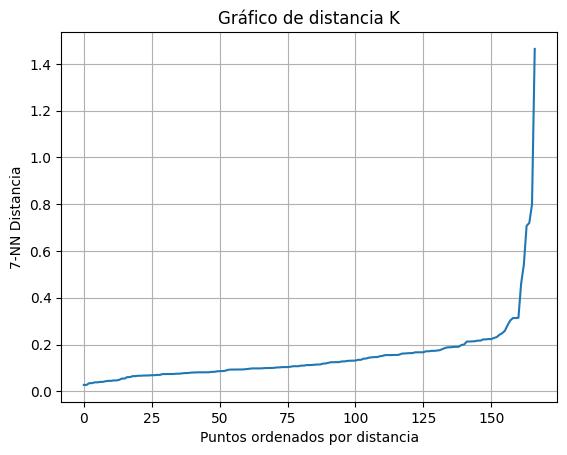

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors = 7)
model = knn.fit(m2)
distances, indices = knn.kneighbors(m2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('7-NN Distancia')
plt.title('Gráfico de distancia K')

- Seleccionamos **minPts** = 8 es decir >= 2 * 3 características
- El valor asignado a los **n_vecinos**: **minPts** - 1.
- Del gráfico anterior, seleccionamos:
     - **eps**: 0,08

In [ ]:
distances

In [9]:
db = DBSCAN(eps = 0.2, min_samples = 8).fit(m2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Número de grupos en etiquetas, ignorando el ruido si está presente
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

data['Class'] = labels; pca_df2['Class'] = labels

Number of Clusters :  3
Number of Outliers :  94


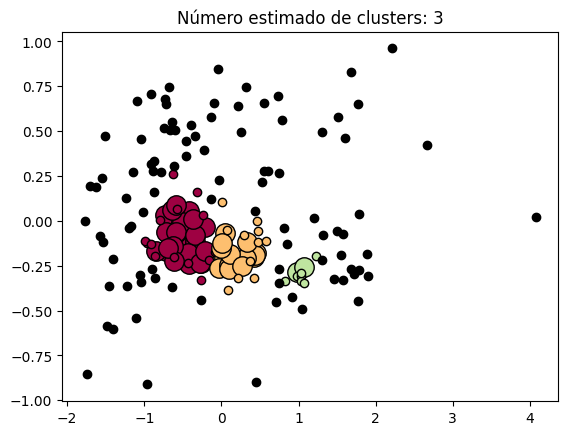

In [10]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = labels == k

    xy = m2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 14)

    xy = m2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 6)

plt.title("Número estimado de clusters: %d" % n_clusters_)
plt.show()

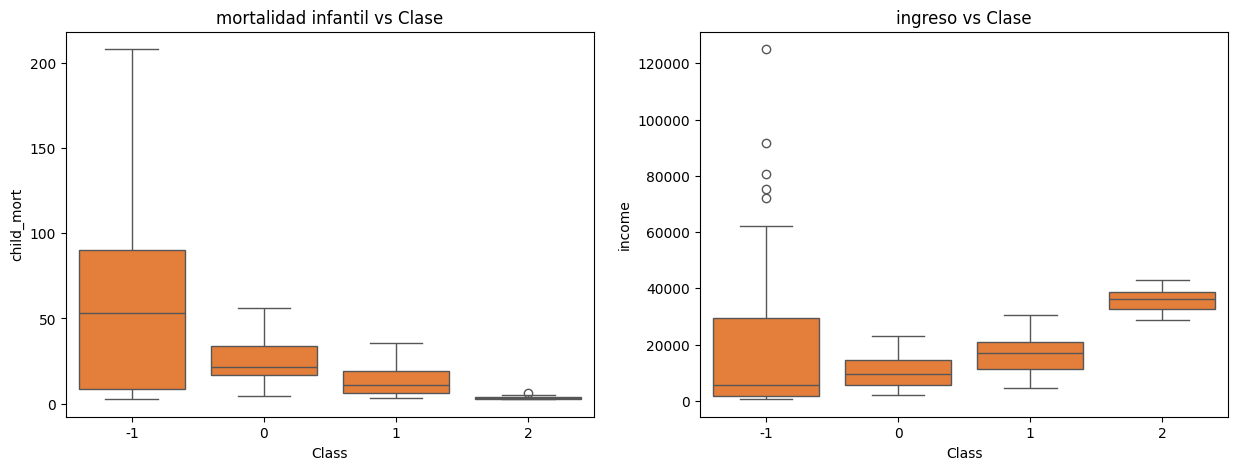

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('mortalidad infantil vs Clase')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F')
plt.title('ingreso vs Clase')

plt.show()

- Del gráfico anterior podemos concluir:
     - **-1: Ruido/Valores atípicos**
     - **0: Se necesita ayuda**
     - **1: Podría necesitar ayuda**
     - **2: No se necesita ayuda**

### Grafica de Clusters

In [12]:
pca_df2.insert(loc = 0, value = list(data['country']), column = 'Country')
pca_df2['Class'].loc[pca_df2['Class'] == -1] = 'Ruido / Outliers'
pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Necesita ayuda'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Podria necesitar ayuda'
pca_df2['Class'].loc[pca_df2['Class'] == 2] ='No Necesita ayuda'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Ayuda necesaria por país (mundo)',
                    color_discrete_sequence=["orange", "red", "green",'black'],
                    color = pca_df2['Class'],  
                    color_discrete_map={'Ruido / Outliers' : 'Black',
                                        'Necesita ayuda':'Red',
                                        'Podria necesitar ayuda':'Yellow',
                                        'No Necesita ayuda':'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')